# Introduction

When it comes to the domain of Natural Language Processing, there are many available pre-trained models that could be useful in fine-tuning in order to get the model more specialized within out use case. Therefore, in this project we are going to:

1. Fine-Tune multiple revisions of BERT (BERT, RoBERTa, DistilBERT) on the **go_emotions** dataset to check which model had performed well.
2. Derive true labels *fixed* on the labels of the **go_emotions** dataset to act as a true label through XLNet with MultipleChoice.
3. Evaluate on how the more sentiment-generalized BERT models could perform accross different use cases ranging from (Finance to Mental Health to NEWS).

The overall flow of the project is shown in <u>Figure 1</u>:

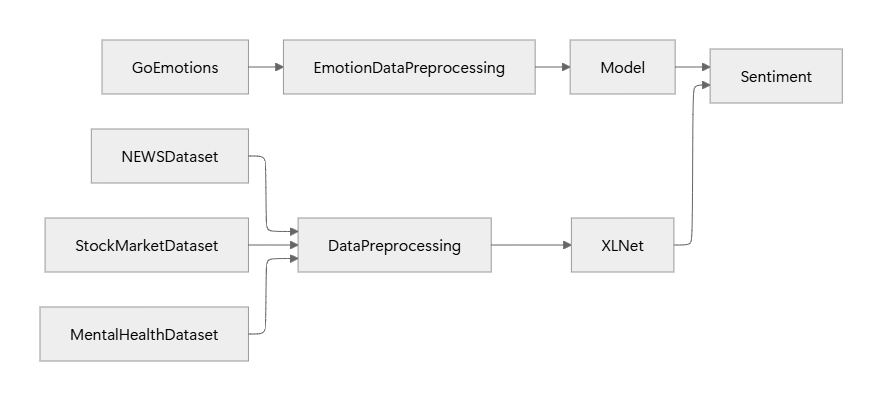

Figure 1


## Analysis on the Training-Set (GoEmotions Dataset by Google)
There are 3 main reasons why we conduct Data Processing:

 (a) Remove symbols and irrelevant content

 (b) Normalise texts to reduce vocabulary size

 (c) Improve tokenisation

In this notebook, GoEmotions Dataset by Google in Kaggle is used. Data cleaning techniques such as RegEx, and stopword removal are used to clean the dataset, before doing tokenization. After that, stemming/lemmatization can be selected as options to reduce vocab size for easier processing. Parts of Speech tagging is used to label the tokens. TF-IDF, NMF and BM25 are then used as part of analysis of the processed dataset.

Before feeding any data into the models, we must analyze the strengths and weaknesses in the data that is being handled. Data in unprocessed datasets can raw and noisy, therefore usually requiring some cleaning and optimization for tokenizers to work. For this project, the data is fed into BERT, RoBERTA, DistilBERT and XLNET, robust transformer-based models whose respective tokenizers prefer raw, unprocessed sentences. These models learn context through stopwords, slang, special characters and punctuation so their removal would reduce accuracy. The objective of our preprocessing is to analyse characteristics in our data, and to demonstrate what we have learned in class.

## Install the Natural Language Toolkit Preprocessing Models

In [ ]:
import os, re, pandas as pd
from pathlib import Path
import nltk
nltk.download('punkt', quiet=True) # NLTK pre-trained tokenizer model
nltk.download('wordnet', quiet=True) # Lexical database for grouping words into sets of synonyms, used for lemmatization
nltk.download('omw-1.4', quiet=True) # WordNet but adds multilingual grouping
nltk.download('stopwords', quiet=True) # List of multilingual stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

DATA_DIR = Path(r'd:\EE6405 NLP Project\Data Preprocessing\dataset')
files = [DATA_DIR / 'go_emotions_dataset_shivamb']
files

The output will show the path of 'files'. For the above cell output:

[WindowsPath('d:/EE6405 NLP Project/Data Preprocessing/dataset/go_emotions_dataset_shivamb')]

## Load selected CSV

In [ ]:
from typing import Optional

def find_text_col(df: pd.DataFrame) -> Optional[str]:
    for cand in ['text','sentence','content','utterance','lyrics','statement']:
        if cand in df.columns:
            return cand
    obj_cols = df.select_dtypes(include='object').columns.tolist()
    return obj_cols[0] if obj_cols else None

def load_one(f: Path) -> Optional[pd.DataFrame]:
    df = pd.read_csv(f)
    text_col = find_text_col(df)
    if text_col is None:
        return None
    df = df.rename(columns={text_col: 'text'})
    df['source_file'] = f.name
    return df

#files = list(DATA_DIR.glob('*.csv'))
#files
print(f"{len(files)} file(s) scheduled")

The output shows the numbers of files scheduled to be loaded. For the above cell output:

1 file(s) scheduled

## Regex Cleaning & Tokenisation
For TF-IDF and BM25 to run efficiently, we need to preprocess the data before tokenisation. We firstly set all words to lowercase, then remove URLs and "@mentions" that tweets sometimes use. We remove "#" from "#hashtags" but keep the content in the hashtag. Next, all the non-alphabetic characters are removed, such as punctuation, digits, emojis and symbols. Repeated whitespaces are normalised to a single space.
Afterwords, tokenisation is done to convert sentences into "tokens" that the machines can understand. Machines cannot understand raw text. It also creates sentence strcuture and sometimes gives each token a "token ID" so models can identify them.

In [ ]:
# Cleaning is to remove noise & normalize text before tokenization

URL_PATTERN = re.compile(r'https?://\S+|www\.\S+') # Removes URLs like http:// or https:// or www.
MENTION_PATTERN = re.compile(r'@[A-Za-z0-9_]+') # Removes Twitter mentions like @username
HASHTAG_PATTERN = re.compile(r'#(\w+)') # Keeps hashtagged words but removes the #
NON_ALPHA_PATTERN = re.compile(r'[^a-zA-Z\s]') # Removes non-alphabetic characters except spaces
MULTISPACE_PATTERN = re.compile(r'\s+') # Replaces multiple spaces with a single space
def basic_clean(text: str) -> str:
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = URL_PATTERN.sub(' ', text)
    text = MENTION_PATTERN.sub(' ', text)
    text = HASHTAG_PATTERN.sub(r'\1', text)
    text = NON_ALPHA_PATTERN.sub(' ', text)
    text = MULTISPACE_PATTERN.sub(' ', text).strip()
    return text

## Stopword Removal
Next, stopwords are removed. Examples include "a, an, the, my, your, i, you, he". These words are useful in helping transformers predict context but are not helpful for term-frequency or bag-of-words based analysis. At this stage you can add in custom stopwords specific to your task. For example a music dataset might add "chorus, verse, repeat, na, la" as stopwords to prevent them topping TF-IDF scores. Our code adds a line removing all words shorter than three letters for efficiency, as they often will not carry meaning.

In [ ]:
stop_words = set(stopwords.words('english')) # NLTK English stop words
DOMAIN_STOP = {"chorus","verse","repeat","na","la"}  # Add domain specific stop words, change as needed
stop_words |= DOMAIN_STOP # Merge both the sets

def tokenize_filter(s: str):
    tokens = word_tokenize(s) # Tokenize text into words
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2] # Remove stop words and words shorter than 3 characters
    return tokens

## Stemming and Lemmatization
Stemming reduces words to their root stem, for example, "study' becomes "studi" and "better" stays as "better". The stemmed words do not have to be proper english words. Lemmatization on the other hand reduces words to their "lemma", or dictionary base form, which has to be proper vocabulary. "study" becomes "study" while "better" becomes "good".
These 2 techniques are done to reduce vocabulary size and also improve generalization, as the model will be able to recognize more word's similar base forms rather than 3 to 4 different words. This increases the future model's training speed and accuracy as it creates a smaller vocabulary that can account for a large range of words.

In [ ]:
stemmer = PorterStemmer() # NLTK Word Stemmer
lemmatizer = WordNetLemmatizer() # NLTK Word Lemmatizer

def stem_tokens(tokens):
    return [stemmer.stem(t) for t in tokens]

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(t) for t in tokens]

## Choose one representation (Lemmatized/Stemmed)

In [ ]:
def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['clean_text']   = df['text'].apply(basic_clean)
    df['tokens']       = df['clean_text'].apply(tokenize_filter)
    df['stemmed']      = df['tokens'].apply(stem_tokens)
    df['lemmatized']   = df['tokens'].apply(lemmatize_tokens)

# Change to df['stemmed'] to use stemmed version
    df['final_text']   = df['lemmatized'].apply(lambda toks: ' '.join(toks)) 
    return df

## Part-of-speech Tagging (POS-Tagging)
POS tagging is the labelling of each word with reference to its corresponding part of speech (eg. noun, verb, adjective). Its main purpose is to allow models to understand sentence structure and meaning. Lemmatization works much more efficiently with POS tagging as it needs to know if the word is a verb, noun or adjective to produce the correct base form.

In [ ]:
import nltk
from collections import Counter

# Ensure POS tagger models are available
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

def add_pos_tags(df: pd.DataFrame) -> pd.DataFrame:
    """Add POS tags for each token list in df['tokens']."""
    df = df.copy()
    if 'tokens' not in df.columns:
        # Fallback: build tokens from clean_text if needed
        df['tokens'] = df['clean_text'].apply(word_tokenize)

    # PTB tags (e.g., NN, VBZ) and Universal tags (e.g., NOUN, VERB)
    df['pos_ptb'] = df['tokens'].apply(lambda toks: nltk.pos_tag(toks))
    df['pos_universal'] = df['tokens'].apply(lambda toks: nltk.pos_tag(toks, tagset='universal'))

    # Counts of Universal POS per doc (useful features)
    df['pos_universal_counts'] = df['pos_universal'].apply(lambda pairs: Counter(tag for _, tag in pairs))
    return df

## Term Frequency-Inverse Document Frequency (TF-IDF)
TF-IDF score is an indicator to show how important a word is in its document relative to the corpus. Term Frequency counts the number of occurrences of a word in a document, while Inverse Document Frequency penalises words commonly found across many documents. High frequency in a document but low frequency in a corpus means high importance as only that document contains that theme. High frequency in both a document and corpus means lower importance as many documents share the same theme.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from pathlib import Path

def _resolve_df_with_final_text():
    glb = globals()
    if 'df_proc' in glb and isinstance(glb['df_proc'], pd.DataFrame) and 'final_text' in glb['df_proc'].columns:
        return glb['df_proc']
    if 'df' in glb and isinstance(glb['df'], pd.DataFrame) and 'final_text' in glb['df'].columns:
        return glb['df']
    try:
        srcs = files
    except NameError:
        raise ValueError("Provide a DataFrame (df_proc/df) with 'final_text' or define 'files'.")
    csvs = []
    for f in srcs:
        p = Path(f)
        if p.is_dir():
            csvs.extend(sorted(p.glob('*.csv')))
            continue
        if p.suffix.lower() != '.csv':
            cand = p.with_suffix('.csv')
            if cand.exists():
                p = cand
        if p.exists() and p.is_file() and p.suffix.lower() == '.csv':
            csvs.append(p)
    if not csvs:
        raise ValueError("No CSVs resolved from 'files'.")
    dfs = []
    for f in csvs:
        d = load_one(Path(f))
        if d is not None:
            dfs.append(preprocess_df(d))
    if not dfs:
        raise ValueError("No valid dataframes built. Check text column detection.")
    return pd.concat(dfs, ignore_index=True)

# Build corpus
df_nmf = _resolve_df_with_final_text()
corpus = df_nmf['final_text'].fillna('')

# TF-IDF
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    lowercase=False  # already lowercased in cleaning
)
X = tfidf.fit_transform(corpus)
print("TF-IDF shape:", X.shape)

import numpy as np
feat = tfidf.get_feature_names_out()
max_scores = X.max(axis=0).toarray().ravel()
top_idx = np.argsort(max_scores)[::-1][:10]
print("\nTop 10 terms (by max TF-IDF across docs):")
for i in top_idx:
    print(f"{feat[i]} -> {max_scores[i]:.4f}")

joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

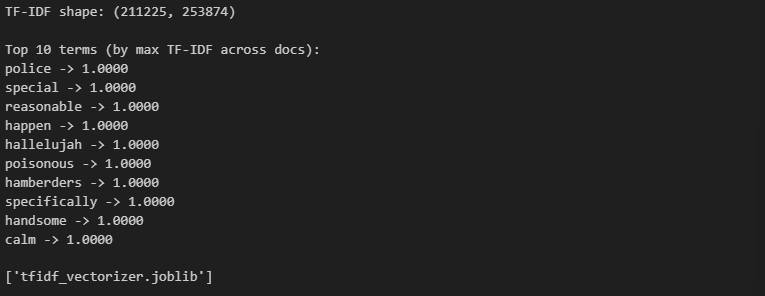

## Non-Negative Matrix Factorisation (NMF)
The next step is Non-Negative Matrix Factorization (NMF). NMF is done to find latent topics within a document. We factorize a Term-Document matrix (from TDF-IDF) into a word-topic matrix and a topic-document matrix. These matrices are then used to infer the semantic relations between words within a sentence.


In [ ]:
from sklearn.decomposition import NMF
import joblib

# Ensure prerequisites exist
assert 'X' in globals() and 'tfidf' in globals() and 'df_nmf' in globals(), "Run the TF-IDF cell first."

# NMF
n_topics = 30  # Split into 30 topics
nmf = NMF(
    n_components=n_topics,
    init='nndsvd',
    random_state=42,
    max_iter=400,
    alpha_W=0.0,
    l1_ratio=0.0
)
W = nmf.fit_transform(X)  # doc-topic matrix
H = nmf.components_      # topic-term matrix
feat = tfidf.get_feature_names_out()

# Show top terms per topic
topn = 12
for k, comp in enumerate(H):
    top_idx = np.argsort(comp)[::-1][:topn]
    terms = [feat[i] for i in top_idx]
    print(f"Topic {k}: {', '.join(terms)}")

# Attach dominant topic to dataframe
df_nmf['nmf_topic'] = W.argmax(axis=1)
df_nmf['nmf_strength'] = W.max(axis=1)

# Persist artifacts
joblib.dump(nmf, 'nmf_model.joblib')
joblib.dump(W, 'nmf_doc_topic.joblib')
joblib.dump(H, 'nmf_topic_term.joblib')
df_nmf.to_csv('df_with_nmf.csv', index=False)

print("NMF done. Doc-topic shape:", W.shape)

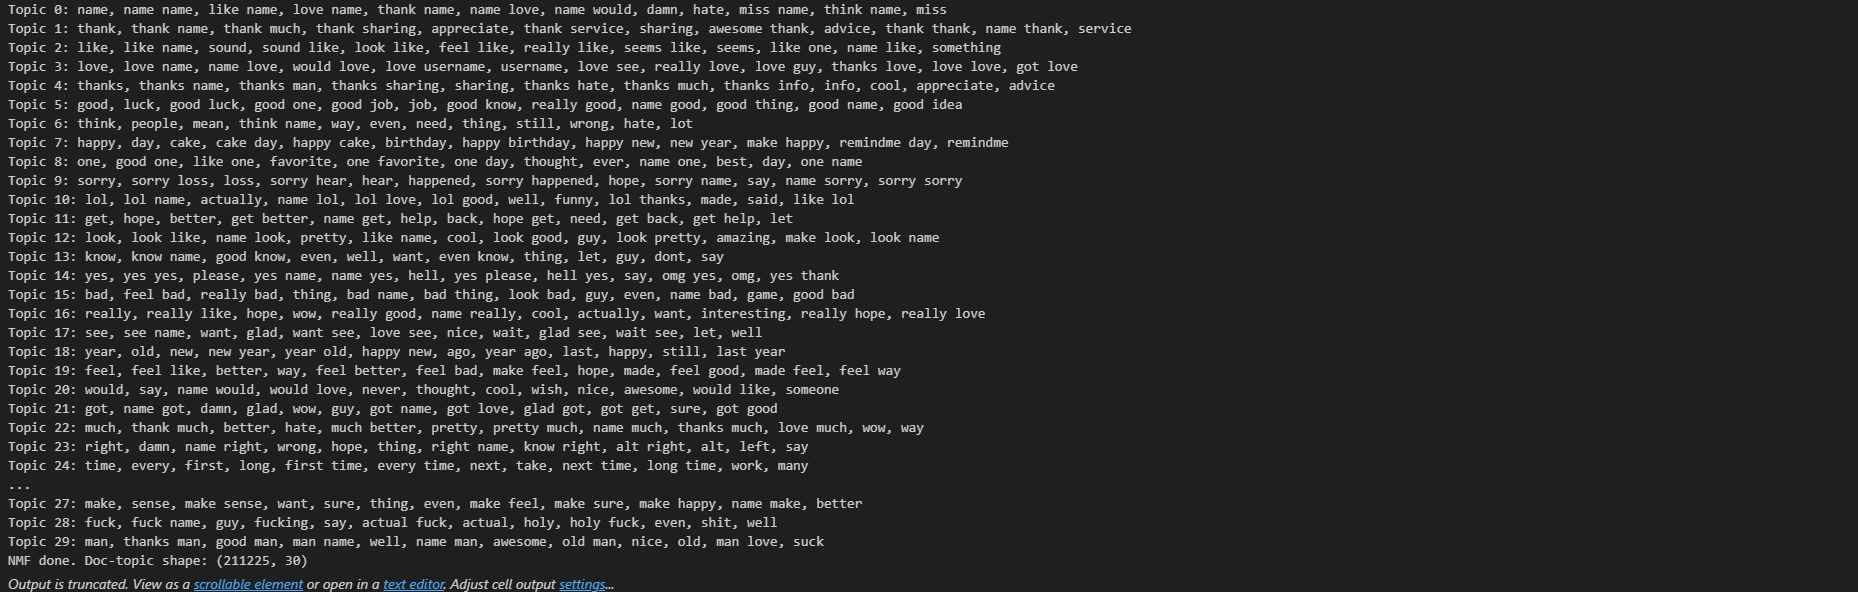

## Best Match 25 (BM25)
BM25 is a ranking algorithm used to measure the relevancy of a document to a given query. The algorithm is considered to be an improvement over TF-IDF as it takes into account document length and is accounts for term frequency saturation. Some limitations of BM25 are that BM25 does not take semantics into account as it only measures how often a term appears. BM25 may not perform as well for extremely short documents due to it heavily relying on document length and term frequency to calculate scores given to a document.

In [ ]:
import sys, subprocess
try:
    from rank_bm25 import BM25Okapi
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rank-bm25"])
    from rank_bm25 import BM25Okapi

import numpy as np

def _df_for_bm25():
    glb = globals()
    if 'df_proc' in glb and isinstance(glb['df_proc'], pd.DataFrame):
        return glb['df_proc']
    try:
        return _resolve_df_with_final_text()
    except Exception as e:
        raise ValueError("No dataframe available. Run preprocessing first.") from e

def _docs_tokens(df_base: pd.DataFrame):
    if 'final_text' in df_base.columns:
        return df_base['final_text'].fillna('').str.split().tolist()
    if 'tokens' in df_base.columns:
        return df_base['tokens'].tolist()
    if 'clean_text' in df_base.columns:
        return df_base['clean_text'].fillna('').apply(word_tokenize).tolist()
    return df_base['text'].fillna('').apply(lambda s: word_tokenize(basic_clean(s))).tolist()

def _prep_query_tokens(q: str):
    q_clean = basic_clean(q)
    toks = tokenize_filter(q_clean)
    return lemmatize_tokens(toks)

# Build index once
df_bm = _df_for_bm25()
docs_tokens = _docs_tokens(df_bm)
bm25 = BM25Okapi(docs_tokens, k1=1.5, b=0.75)

def bm25_search_rank(df_base: pd.DataFrame, query: str, top_k=10):
    q_toks = _prep_query_tokens(query)
    scores = bm25.get_scores(q_toks)
    top_idx = np.argsort(scores)[::-1][:top_k]
    out = df_base.iloc[top_idx].copy()
    out['bm25_score'] = np.array(scores)[top_idx]
    cols = [c for c in ['bm25_score', 'final_text', 'text', 'source_file'] if c in out.columns]
    return out[cols]

print("'final_text' is the post-processed text used for BM25 search.\n'text' is the original pre-processed text.\n")
# Input word query here
results = bm25_search_rank(df_bm, "water", top_k=10)
print(results.head(10))

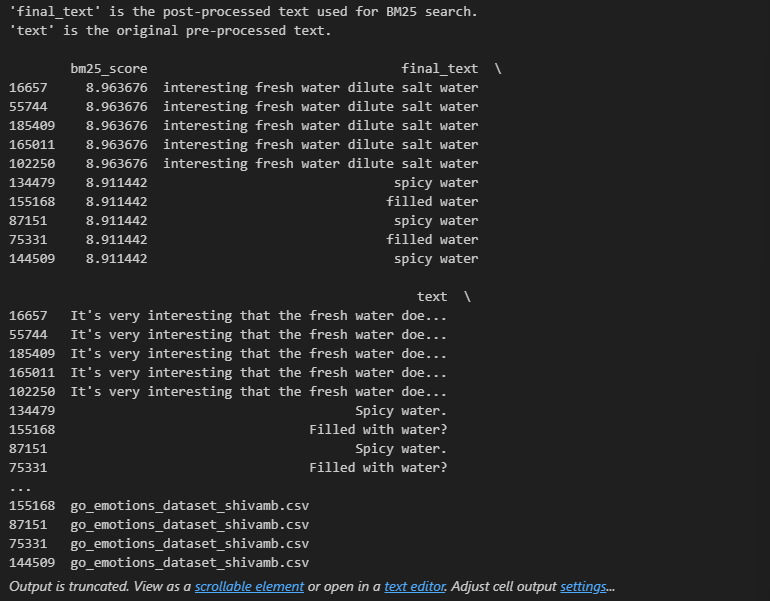

# Machine Learning Approach

## BERT and its Variants

For this project, we will be training different variants of the BERT algorithm in order to compute the most optimal and efficient model that could be used to be evaluated against the XLNet Model. More specifically, we would be training the original BERT and 3 variants of:

1. BERT
2. RoBERTA
3. DistilBERT

We would then be comparing  the models, against each other to compare the performance, training stability and their effectiveness in determining the sentiment of the text.

<u>Figure 2</u> shows the progression of the loss over the epochs

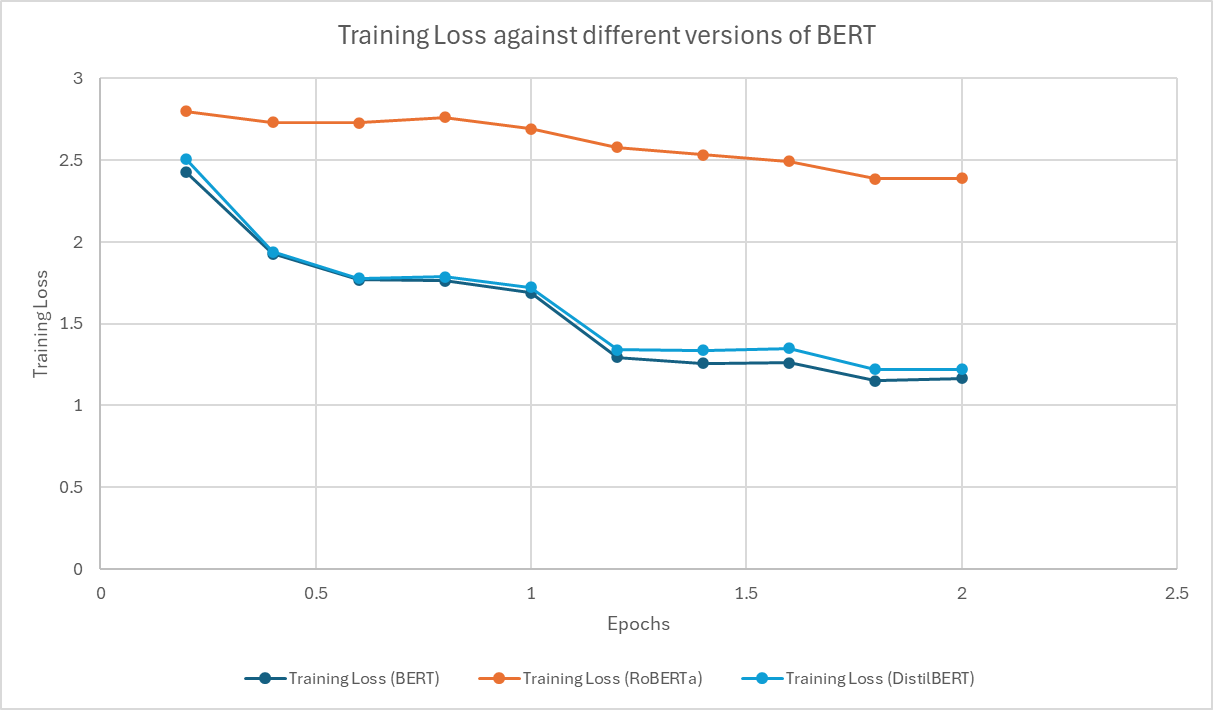

Figure 2

From the training-loss, it can be observed that RoBERTa had performed poorly compared to the other 2 variants with an average loss over the training epochs of **2.609** versus an average of **1.60** for the other two. The code below shows the training & testing algorithm used to train the BERT variants.


In [ ]:
# Importing the Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

# Getting the Dataset
training_set = load_dataset('go_emotions')

num_training_samples = 10000

# Initializing the BERTS
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

# Initializing a list of Models
map_of_models = {"BERT": "bert-base-uncased",
                 "RoBERTa": "FacebookAI/roberta-base",
                 "DistilBERT": "distilbert-base-uncased"}

# Initializing the tokenizer
model_name = "RoBERTa" # Just input what model you want and the algorithm would automatically load all of the essential components
tokenizer = AutoTokenizer.from_pretrained(map_of_models[model_name])
model = AutoModelForSequenceClassification.from_pretrained(map_of_models[model_name], num_labels = 28)
cce = evaluate.load("accuracy")

# Loop to tokenize the data
def tokenize(dataset):
    return tokenizer(dataset['text'], padding='max_length', truncation=True)

# Processing the labels
def return_one_label(dataset):
    dataset['labels'] = dataset['labels'][0]
    return dataset # Only returning the first label of the traub

tokenized_dataset = training_set.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.map(return_one_label)


training_args = TrainingArguments(
    output_dir= f"{model_name}_trained_weights",
    per_device_train_batch_size = 4, 
    per_device_eval_batch_size = 4, 
    num_train_epochs = 2,
    push_to_hub = False
)

# Training the Model
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset= tokenized_dataset['train'].shuffle(seed=14).select(range(num_training_samples)),
    eval_dataset = tokenized_dataset['validation'].shuffle(seed=14).select(range(num_training_samples//2))
)

trainer.train()
print(trainer.evaluate())

In [ ]:
# Importing the Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer

# Initializing a list of Models
map_of_models = {"BERT": "bert-base-uncased",
                 "RoBERTa": "FacebookAI/roberta-base",
                 "DistilBERT": "distilbert-base-uncased"}

map_of_paths = {"BERT": "BERT_trained_weights\checkpoint-5000",
                "RoBERTa": "RoBERTa_trained_weights\checkpoint-5000",
                "DistilBERT": "DistilBERT_trained_weights\checkpoint-5000"}



# Initializing 

# Initializing the tokenizer
model_name = "BERT"

model = pipeline(task = 'sentiment-analysis', model=map_of_paths[model_name], tokenizer=AutoTokenizer.from_pretrained(map_of_models[model_name]))

print(model("WAKE UP! GEORGE SOROS “Drastically Ramps Up” Effort To Destroy America")) # Input the sentence to get the sentiment

### Evaluation

This section shows how our model had performed within a general framework:

Given 6 sentences (Sentence A to F), below is the table to show the sentences & their outcomes:

---

#### Sentences

Sentence A: I'm struggling to get a reason to keep going  It's just so hard. I've been trying to find a way to get better, but I just can't. (*Mental Health*)

Sentence B: Barclays share price subdued as bank faces fresh forex probe. (*Finance*)

Sentence C: COVER-UP: Both Obama and Clinton Lied About Trading Classified Emails. (*News*)

Sentence D: The buyer is real estate owner Propertos Oy , but the companies have agreed not to disclose financial details of the deal . (*Finance*)

Sentence E: Will you lose all your files? (*Mental Health*)

Sentence F: WAKE UP! GEORGE SOROS “Drastically Ramps Up” Effort To Destroy America. (*News*)

--- 

#### Outcomes

Sentence A:
* BERT: Disappointment
* RoBERTa: Neutral
* DistilBERT: Sadness
* **XLNet: Optimism**

Sentence B:
* BERT: Neutral
* RoBERTa: Neutral
* DistilBERT: Neutral
* **XLNet: Realization**

Sentence C:
* BERT: Neutral
* RoBERTa: Neutral
* DistilBERT: Neutral
* **XLNet: Optimism**

Sentence D:
* BERT: Neutral
* RoBERTa: Neutral
* DistilBERT: Neutral
* **XLNet: Fear**

Sentence E:
* BERT: Curiosity
* RoBERTa: Neutral
* DistilBERT: Curiosity
* **XLNet: Fear**

Sentence F:
* BERT: Neutral
* RoBERTa: Neutral
* DistilBERT: Neutral
* **XLNet: Greif**


## XLNet Analysis

The primary purpose of the XLNet was to standardize the labels from different datasets to test the performance of our fine-tuned BERT model on different situations, the implementation of the XLNet involves:

1. Implemented the sentiment classification workflow using a pretrained XLNet model and used it for a multiple choice prediction format.
2. Prepared the datasets by extracting sample sentences, applied prompt based encoding, and generated fixed sentiment labels (options) as the choices.
3. Applied softmax and argmax to determine the predicted sentiment label.
4. Ran the analysis across GoEmotions, Mental Health, Finance and News datasets.
5. This then shows XLNet's ability to capture sentiment cues and compares it's interpretability and behavior against the BERT variant models used in this project.
6. XLNet successfully generated sentiment predictions across mixed datasets.
7. The fixed sentiment label choices worked well.

In [ ]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, XLNetForMultipleChoice
import torch
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained("xlnet/xlnet-base-cased")
model = XLNetForMultipleChoice.from_pretrained("xlnet/xlnet-base-cased")

map_of_datasets = {"Finance": r"/Users/nitheeshsundaram/Downloads/NLP datasets/data.csv",
                   "Mental Health": r"/Users/nitheeshsundaram/Downloads/NLP datasets/Combined Data.csv",
                   "Fake News": r"/Users/nitheeshsundaram/Downloads/NLP datasets/Fake News.csv",
                   "Emotions": r"/Users/nitheeshsundaram/Downloads/NLP datasets/go_emotions_dataset.csv"}


mode = "Mental Health"  # change to "Finance" or "Genius" or "Emotions" to test other datasets

dataset = pd.read_csv(map_of_datasets[mode]).sample(10)

if mode == "Mental Health":
    dataset.rename(columns={"statement": "Sentence"}, inplace=True)
elif mode == "Fake News":
    dataset.rename(columns={"title": "Sentence"}, inplace=True)

# Initializing the choices
choice_0 = "admiration"
choice_1 = "amusement"
choice_2 = "anger"
choice_3 = "annoyance"
choice_4 = "approval"
choice_5 = "caring"
choice_6 = "confusion"
choice_7 = "curiosity"
choice_8 = "desire"
choice_9 = "disappointment"
choice_10 = "disapproval"
choice_11 = "disgust"
choice_12 = "embarrassment"
choice_13 = "excitement"
choice_14 = "fear"
choice_15 = "gratitude"
choice_16 = "greif"
choice_17 = "joy"
choice_18 = "love"
choice_19 = "nervousness"
choice_20 = "optimism"
choice_21 = "pride"
choice_22 = "realization"
choice_23 = "relief"
choice_24 = "remorse"
choice_25 = "sadness"
choice_26 = "surprise"
choice_27 = "neutral"

num_sentiment_map = {0: "admiration",
                     1: "amusement",
                     2: "anger",
                     3: "annoyance",
                     4: "approval",
                     5: "caring",
                     6: "confusion",
                     7: "curiosity",
                     8: "desire",
                     9: "disappointment",
                     10: "disapproval",
                     11: "disgust",
                     12: "embarrassment",
                     13: "excitement",
                     14: "fear",
                     15: "gratitude",
                     16: "greif",
                     17: "joy",
                     18: "love",
                     19: "nervousness",
                     20: "optimism",
                     21: "pride",
                     22: "realization",
                     23: "relief",
                     24: "remorse",
                     25: "sadness",
                     26: "surprise",
                     27: "neutral"
                     }

for _, prompt in dataset.iterrows():
    labels = torch.tensor(0).unsqueeze(0)  # choice0 is correct (according to Wikipedia ;)), batch size 1

    # Prompt engineering start every sentence with "The sentiment of the sentence is:"
    encoding = tokenizer([f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}",
                          f"The closest sentiment for {mode} of the sentence is: {prompt['Sentence']}"],
                         [choice_0, 
                          choice_1, 
                          choice_2, 
                          choice_3, 
                          choice_4, 
                          choice_5, 
                          choice_6,
                          choice_7,
                          choice_8,
                          choice_9,
                          choice_10,
                          choice_11,
                          choice_12,
                          choice_13,
                          choice_14,
                          choice_15,
                          choice_16,
                          choice_17,
                          choice_18,
                          choice_19,
                          choice_20,
                          choice_21,
                          choice_22,
                          choice_23,
                          choice_24,
                          choice_25,
                          choice_26,
                          choice_27],
                         return_tensors="pt", padding=True)
    outputs = model(**{k: v.unsqueeze(0) for k, v in encoding.items()}, labels=labels)  # batch size is 1

    # the linear classifier still needs to be trained
    loss = outputs.loss
    logits = outputs.logits
    print(f" For the sentence: {prompt['Sentence']}, \n-------->the Sentiment is: {num_sentiment_map[int(torch.argmax(F.softmax(logits, dim=-1)))]}")


# import pandas as pd
# import numpy as np

# # Getting a mixed training set
# ts_1 = pd.read_csv("/Users/nitheeshsundaram/Downloads/NLP datasets/data.csv")["Sentence"].sample(100) # Finance
# ts_2 = pd.read_csv("/Users/nitheeshsundaram/Downloads/NLP datasets/Combined Data.csv")
# ts_2.rename(columns={"statement": "Sentence"}, inplace=True)
# ts_2 = ts_2["Sentence"].sample(100) # Mental Health
# ts_3 = pd.read_csv("/Users/nitheeshsundaram/Downloads/NLP datasets/Fake News.csv")
# ts_3.rename(columns={"title": "Sentence"}, inplace=True)
# ts_3 = ts_3["Sentence"].sample(100) # Fake News

# fin = pd.DataFrame(["Finance"]*100, columns=["Type"])
# mh = pd.DataFrame(["Mental Health"]*100, columns=["Type"])
# fn = pd.DataFrame(["Fake News"]*100, columns=["Type"])

# ts_1 = np.array(pd.concat((ts_1.reset_index(drop=True), fin), axis=1))
# ts_2 = np.array(pd.concat((ts_2.reset_index(drop=True), mh), axis=1))
# ts_3 = np.array(pd.concat((ts_3.reset_index(drop=True), fn), axis=1))

# final = np.concatenate((ts_1, ts_2, ts_3), axis=0)

# pd.DataFrame(final, columns=["Sentence", "Type"]).sample(300).to_csv("/Users/nitheeshsundaram/Downloads/NLP datasets/combined_testing.csv", index=False)


## Expected Outcomes

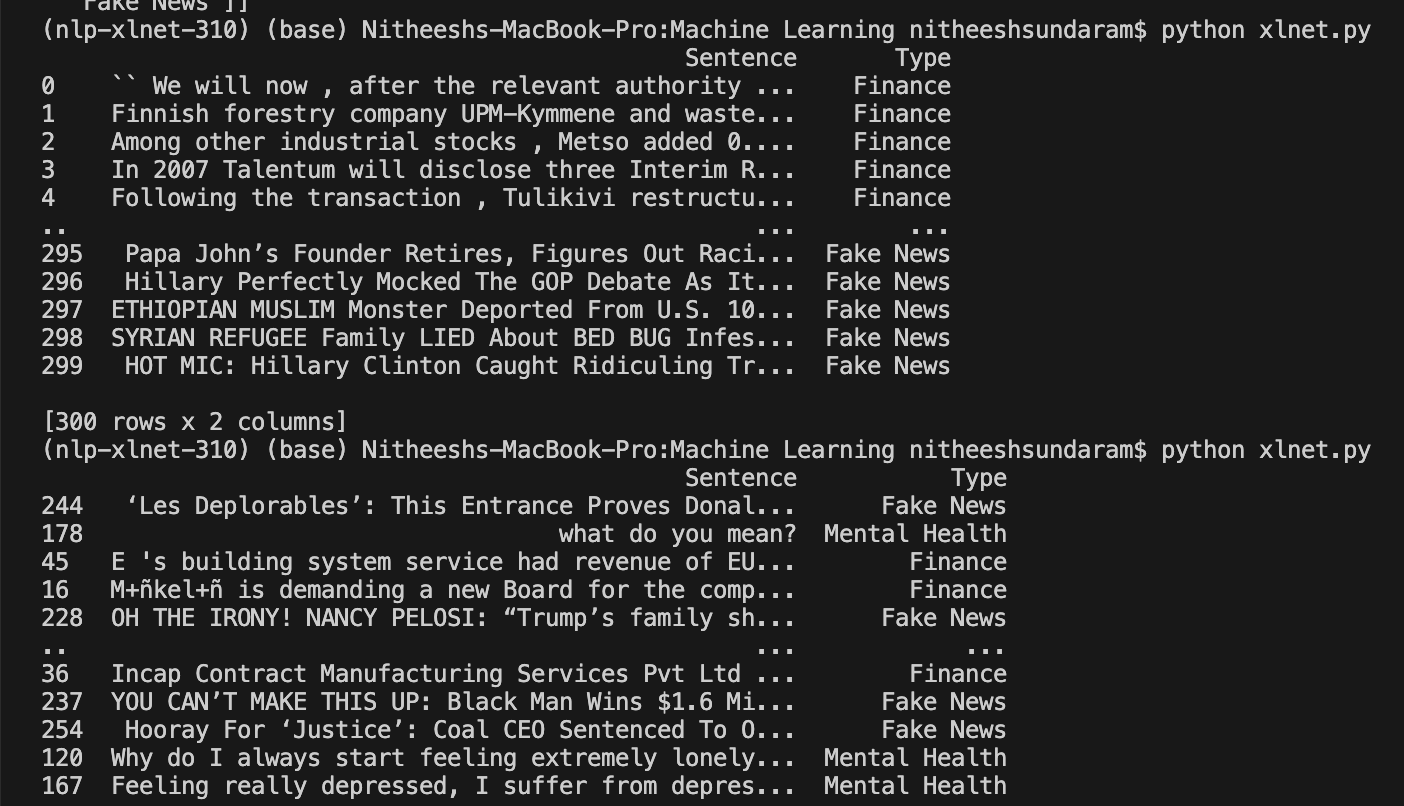

# Streamlit interface

There are two tabs to the streamlit interface, the prediction tab and metrics tab with all the models. Figure 3 shows the prediction tab and figure 4 shows the metrics tab.

1. Each model is loaded from its checkpoint, and the tokenizer is loaded from the tokenizer.json (save_tokenizer,py), which is from AutoTokenizer from the transformers library.
2. A run_card.json is created with a utility function script (write_run_card.py), and for each card (one card per model), the run_id will be shown on the sidebar so users can select the model.
3. Users can choose which model to select, and type in a sentence within the textfield and click on the predict button to run predictions based on the chosen model. The probabilities for each class will additionally be calculated and represented in a bar chart below the final predicted emotion. This is amongst the 28 emotions listed.
4. We then ran inference on our UI for 5 randomly chosen lines in our demo, from a csv we compiled from the Fakenews, Finance and MentalHealth dataset which we included in our reference.
5. The metrics tab shows each model, where they all take in 28 classes. Below, the training loss plot for all the models is shown.

Utilities codes such as save_tokenizer.py and write_run_card.py are to save a tokenizer.json file for each model to load on the frontend and for card.json to display information on the metrics tab.

In [ ]:
# save_tokenizer.py

import os, json
from transformers import AutoTokenizer

run_dir = r"artifacts\albert-checkpoint-5000"  

TOKENIZER_NAME = "albert-base-v2"
tok = AutoTokenizer.from_pretrained(TOKENIZER_NAME, use_fast=True)
tok.save_pretrained(run_dir)

print("Tokenizer saved to:", run_dir)

# write_run_card.py

import json, os

run_dir = r"artifacts\albert-checkpoint-5000" 

LABELS_28 = [
    "admiration","amusement","anger","annoyance","approval","caring","confusion",
    "curiosity","desire","disappointment","disapproval","disgust","embarrassment",
    "excitement","fear","gratitude","grief","joy","love","nervousness","optimism",
    "pride","realization","relief","remorse","sadness","surprise","neutral"
]

run_card = {
    "run_id": "albert_model",
    "family": "transformer",
    "model_name": "albert-base-v2",
    "tokenizer_name": "albert-base-v2",
    "params": {"max_len": 128},
    "metrics": {},                       
    "label_classes": LABELS_28
}
with open(os.path.join(run_dir, "run_card.json"), "w") as f:
    json.dump(run_card, f, indent=2)

print("Wrote run_card.json to", run_dir)


Prediction tab:

Prediction tab with side bar for model selection through a dropdown, main page shows the prediction and chart. The text in the input field is a randomly input text for demonstration.

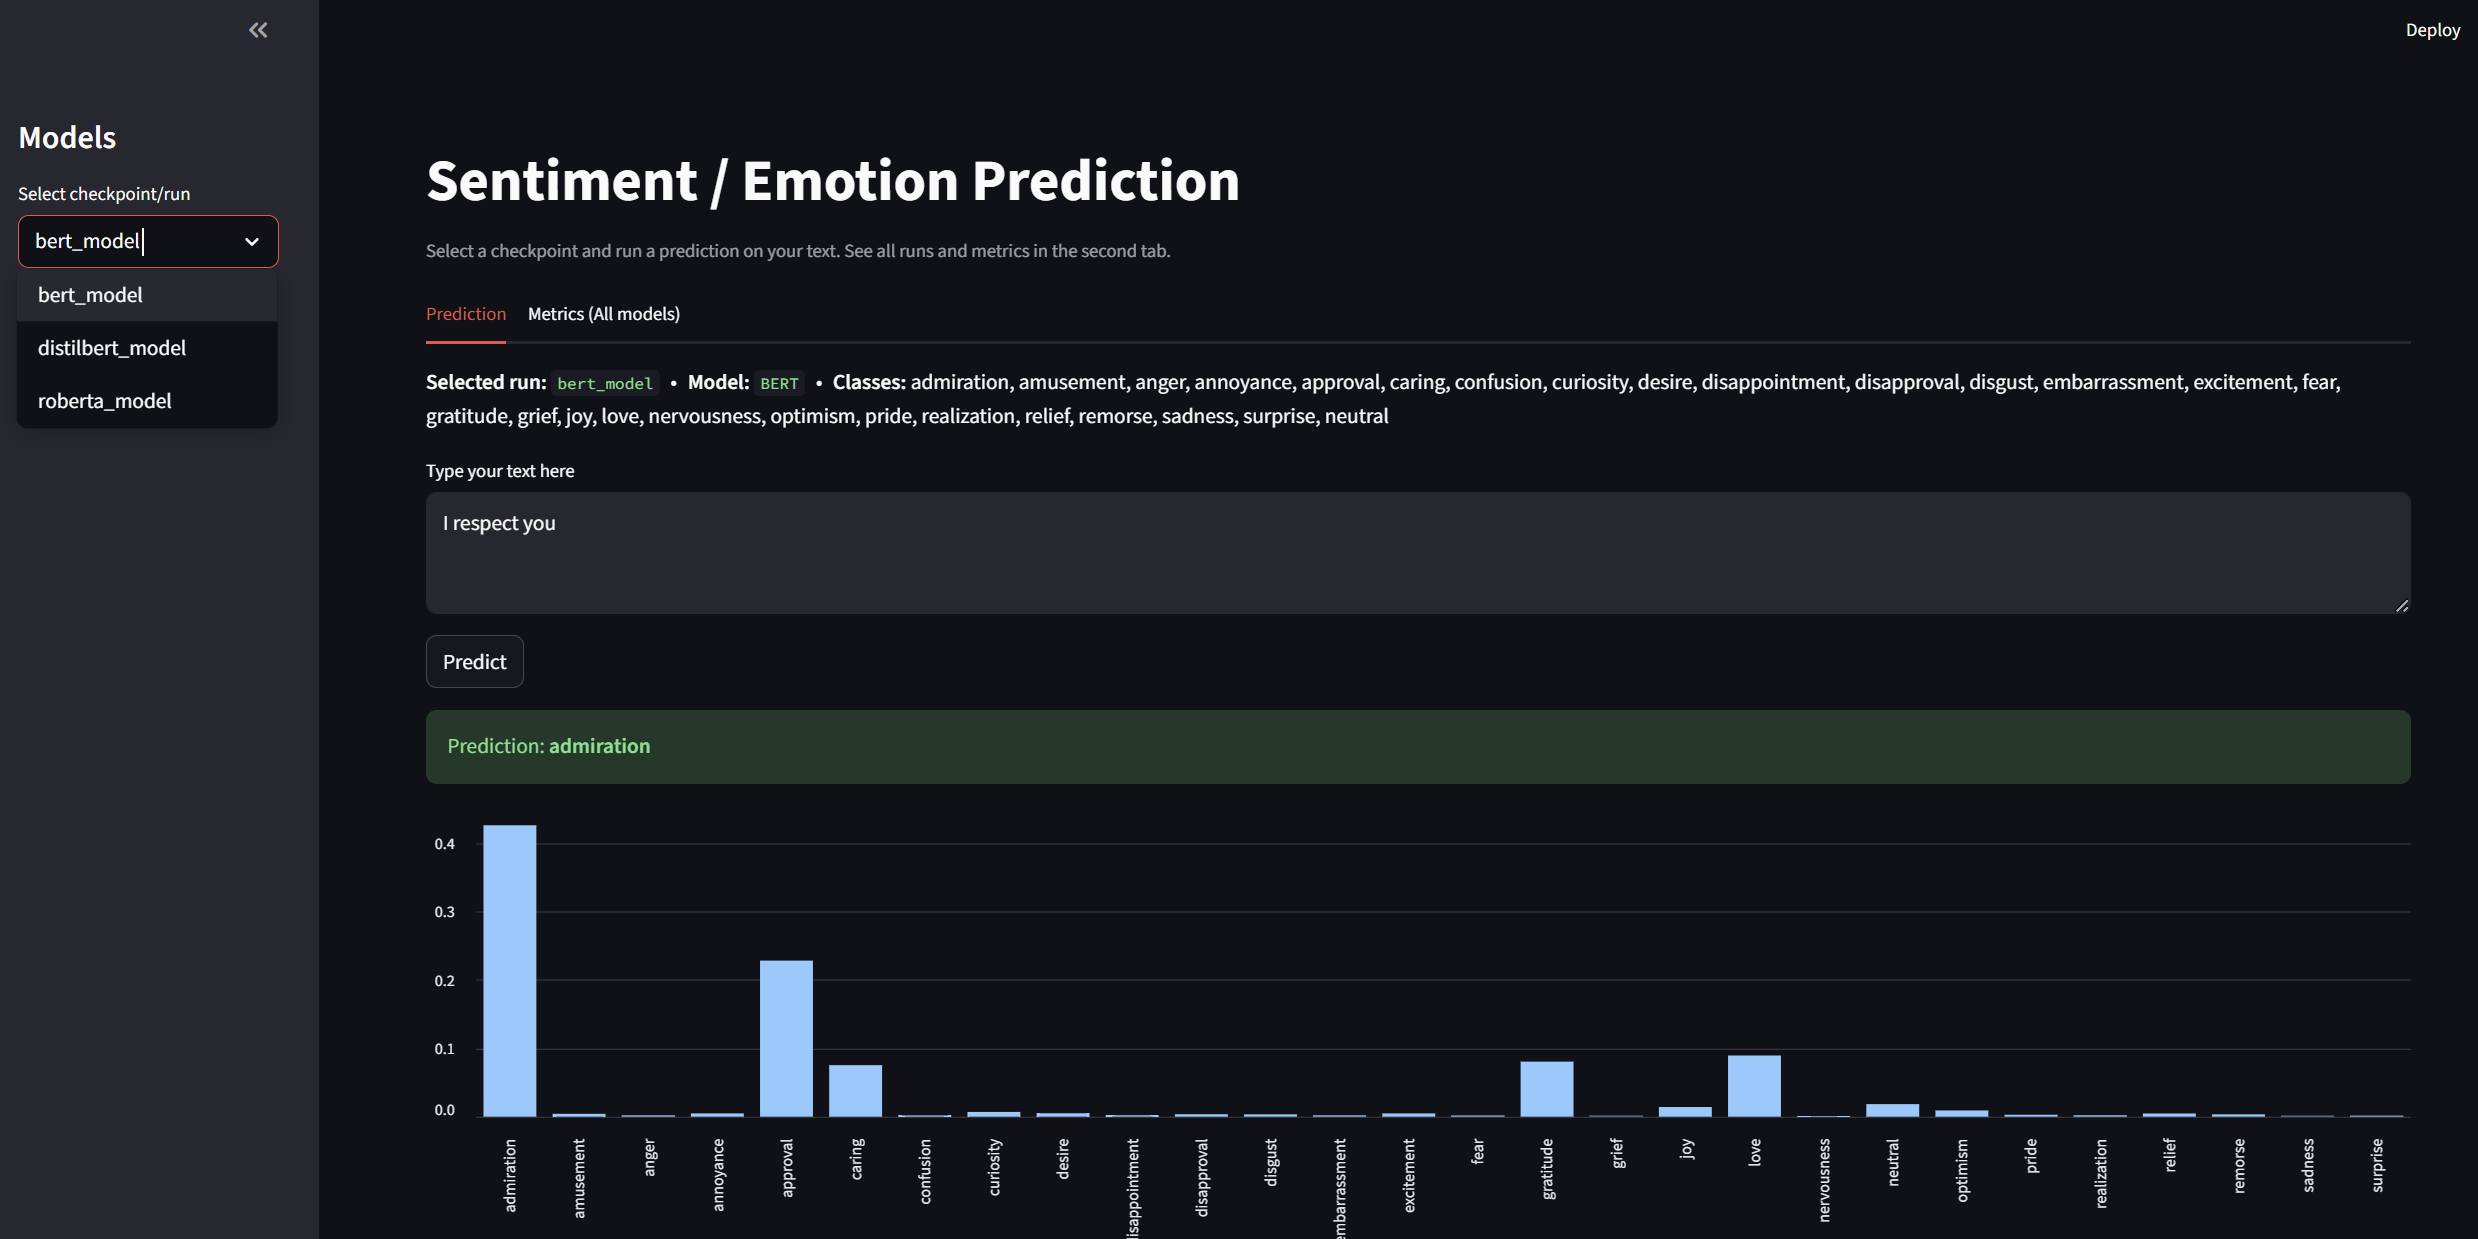
Figure 3

Please refer to app.py for the full interface. Below are code snippets for the code breakdowns.

In [ ]:
# Code snippet from app.py on displaying runs table

# Importing the Essential Libraries
import os, json
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import streamlit as st

import joblib
import torch
from transformers import pipeline

ARTIFACTS_DIR = "artifacts"

def discover_runs(art_dir: str = ARTIFACTS_DIR) -> Dict[str, Dict]:
    found = {}
    if not os.path.isdir(art_dir):
        return found
    for name in os.listdir(art_dir):
        rd = os.path.join(art_dir, name)
        rc_path = os.path.join(rd, "run_card.json")
        if os.path.isdir(rd) and os.path.isfile(rc_path):
            try:
                with open(rc_path) as f:
                    meta = json.load(f)
                meta["_path"] = rd
                found[meta["run_id"]] = meta
            except Exception:
                pass
    return found

# It is then used to load the checkpoints

ALL_RUNS = discover_runs()

st.sidebar.title("Models")
if not ALL_RUNS:
    st.sidebar.warning("No checkpoints found in ./artifacts/. Drop your trained runs there.")
run_ids_sorted = sorted(ALL_RUNS.keys())
run_choice = st.sidebar.selectbox("Select checkpoint/run", run_ids_sorted, index=0 if run_ids_sorted else None)

st.title("Sentiment / Emotion Prediction")
st.caption("Select a checkpoint and run a prediction on your text. See all runs and metrics in the second tab.")

# Tabs
tab_predict, tab_all = st.tabs(["Prediction", "Metrics (All models)"])

In [ ]:
# Code snippet from app.py on prediction, modified for multi-label classification

def _cuda_ok() -> bool:
    if not torch.cuda.is_available():
        return False
    try:
        torch.zeros(1, device="cuda")
        return True
    except Exception:
        return False

@st.cache_resource
def _cached_pipe(model_dir: str, tokenizer_src: str, use_cuda: bool):
    return pipeline(
        task="text-classification",
        model=model_dir,
        tokenizer=tokenizer_src,
        device=0 if use_cuda else -1,
        return_all_scores=True,   # get scores for all labels
        truncation=True
    )

def load_predictor(run_card: Dict):
    """
    Return (predict, predict_proba, class_names, family)
    using a HF pipeline.
    """
    path = run_card["_path"]
    family = "transformer"

    # Tokenizer source uses checkpoint first, else fall back to run_card.
    has_tok = any(
        os.path.exists(os.path.join(path, fn))
        for fn in ("tokenizer.json", "vocab.txt", "spiece.model")
    )
    tok_src = path if has_tok else run_card.get("tokenizer_name", path)

    pipe = _cached_pipe(path, tok_src, _cuda_ok())

    # Prefer labels from the model config (ground truth)
    cfg = pipe.model.config
    class_names = run_card.get("label_classes", [])
    try:
        num_labels = int(getattr(cfg, "num_labels", len(class_names) or 0))
        id2label = getattr(cfg, "id2label", None)
        if id2label and num_labels:
            class_names = [
                id2label[i] if isinstance(id2label, dict) and i in id2label
                else id2label[str(i)] if isinstance(id2label, dict) and str(i) in id2label
                else class_names[i] if i < len(class_names)
                else f"LABEL_{i}"
                for i in range(num_labels)
            ]
        elif not class_names and num_labels:
            class_names = [f"LABEL_{i}" for i in range(num_labels)]
    except Exception:
        if not class_names:
            class_names = ["admiration","amusement","anger","annoyance","approval","caring","confusion",
                        "curiosity","desire","disappointment","disapproval","disgust","embarrassment",
                        "excitement","fear","gratitude","grief","joy","love","nervousness","optimism",
                        "pride","realization","relief","remorse","sadness","surprise","neutral"] # just a fallback

    name_to_idx = {n: i for i, n in enumerate(class_names)}

    def _row_to_probs(row):
        """
        row is a list of dicts from the pipeline:
          [{"label": "admiration", "score": 0.12}, ...]
        Convert to a fixed-length vector aligned to class_names.
        """
        vec = np.zeros(len(class_names), dtype=np.float32)
        for d in row:
            lab = d["label"]
            j = name_to_idx.get(lab)
            if j is None and lab.startswith("LABEL_"):
                try:
                    j = int(lab.split("_")[-1])
                except Exception:
                    j = None
            if j is not None and 0 <= j < len(vec):
                vec[j] = float(d["score"])
        s = float(vec.sum())
        if s > 0:
            vec /= s  # make sure sums to 1
        return vec

    def predict_proba(texts: List[str]) -> np.ndarray:
        outs = pipe(texts)
        return np.vstack([_row_to_probs(row) for row in outs])

    def predict(texts: List[str]) -> np.ndarray:
        return predict_proba(texts).argmax(axis=-1)

    return predict, predict_proba, class_names, family

# this is then used to load the predictor and make predictions

# -------------------- PREDICT
with tab_predict:
    if not run_choice:
        st.info("Pick a checkpoint on the left.")
    else:
        rc = ALL_RUNS[run_choice]
        st.markdown(f"**Selected run:** `{rc['run_id']}` • **Model:** `{rc['model_name']}` • **Classes:** {', '.join(rc['label_classes'])}")
        predict, predict_proba, classes, family = load_predictor(rc)

        text = st.text_area("Type your text here", "I respect you", height=120)
        if st.button("Predict"):
            probs = predict_proba([text])[0]
            pred_id = int(np.argmax(probs))

            #replace with words instead of label numbers
            Emotions_28 = ["admiration","amusement","anger","annoyance","approval","caring","confusion",
                        "curiosity","desire","disappointment","disapproval","disgust","embarrassment",
                        "excitement","fear","gratitude","grief","joy","love","nervousness","optimism",
                        "pride","realization","relief","remorse","sadness","surprise","neutral"]

            display_classes = Emotions_28 if classes and classes[0].upper().startswith("LABEL_") else classes

            st.success(f"Prediction: **{display_classes[pred_id]}**")
            dfp = pd.DataFrame({"class": display_classes, "probability": probs})
            st.bar_chart(dfp.set_index("class"))

Metrics tab:

This tab takes from run_card.json, showing the tokenizer used for each model. The graph below shows the training loss of the models.

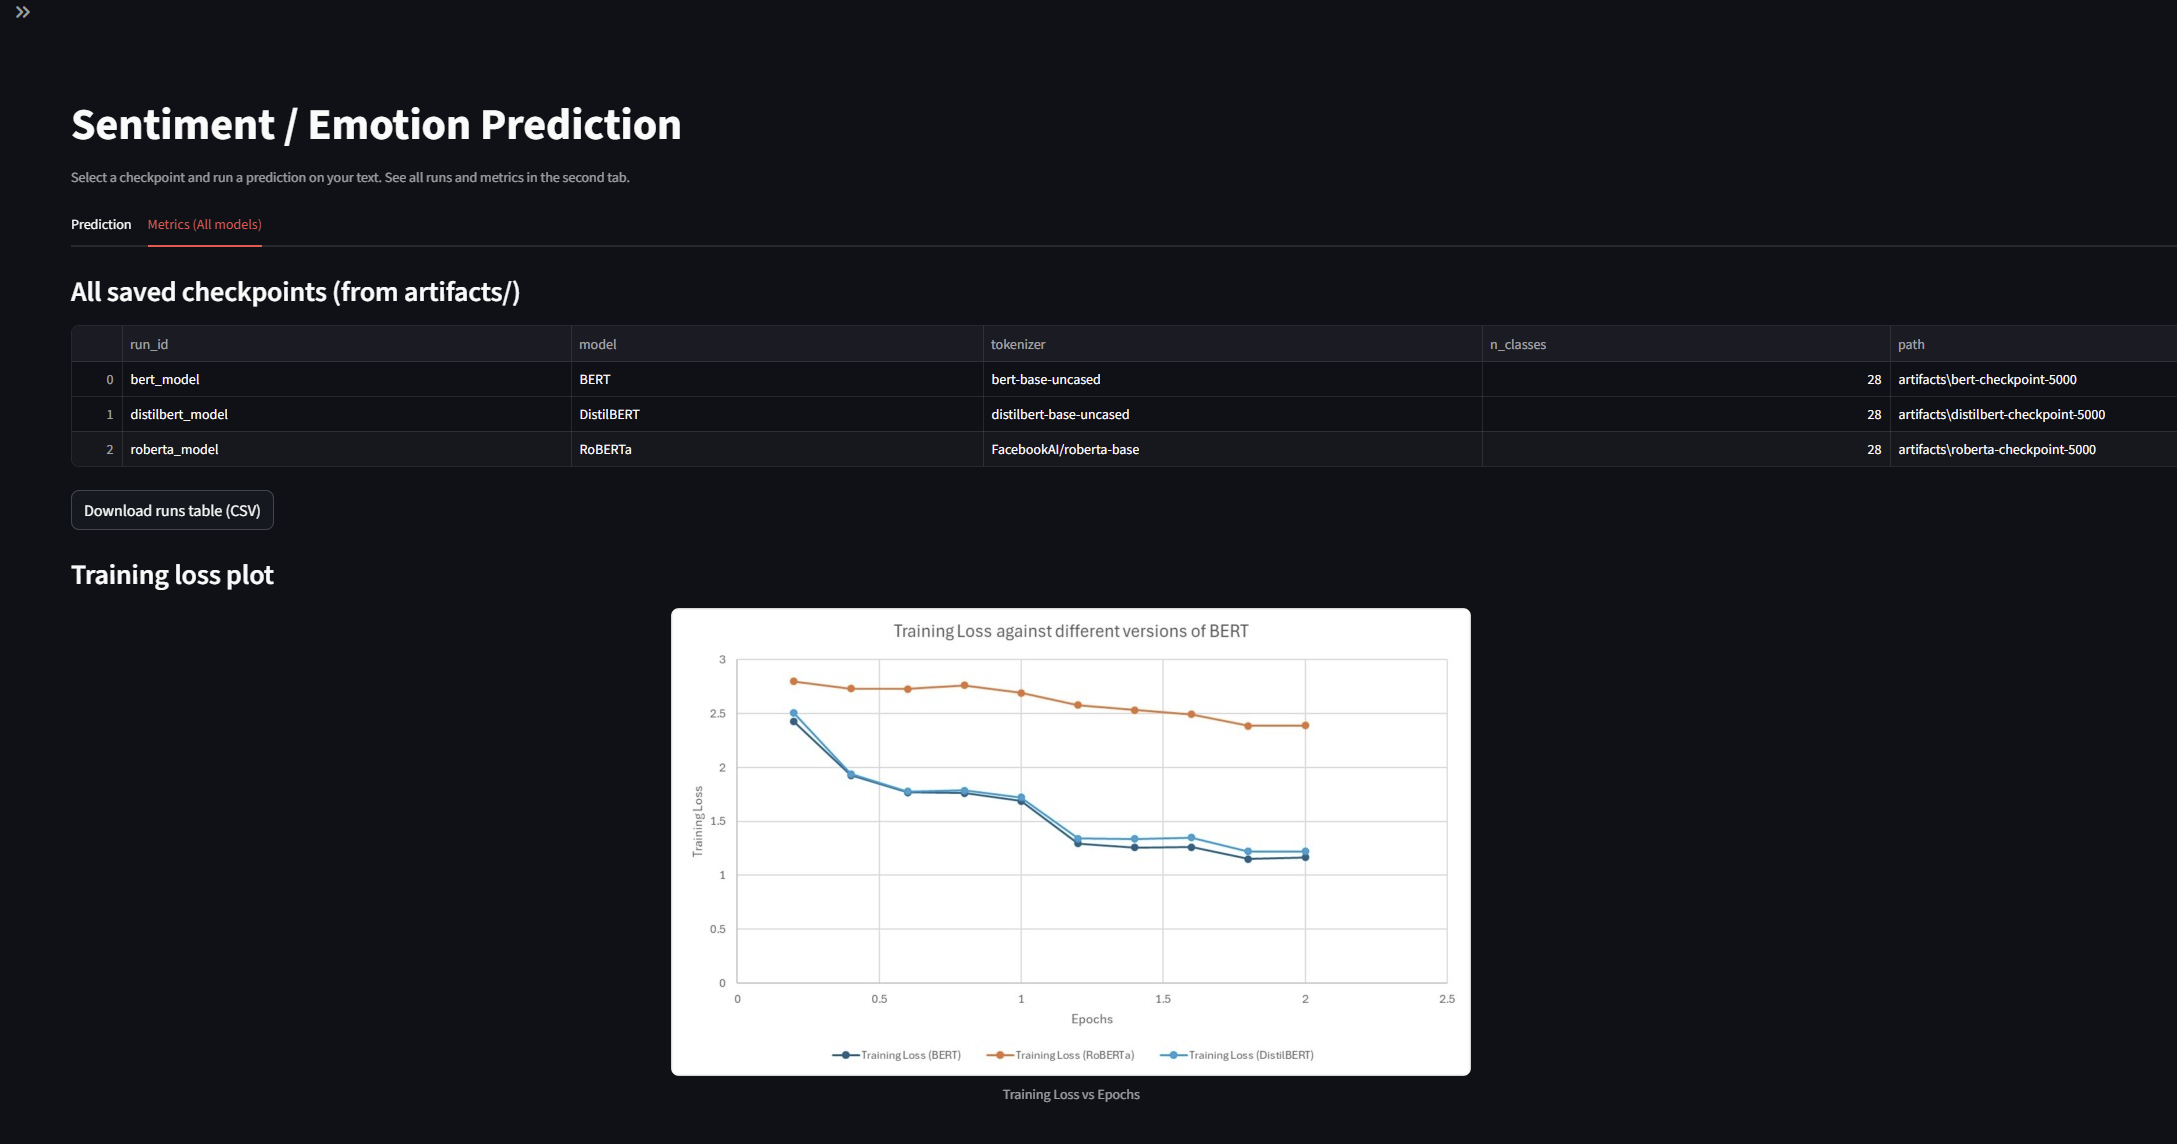
Figure 4

In [ ]:
# Code snippet from app.py on displaying all runs

# -------------------- ALL RUNS
with tab_all:
    st.subheader("All saved checkpoints (from artifacts/)")
    if not ALL_RUNS:
        st.info("No checkpoints found.")
    else:
        rows = []
        for rid, rc in ALL_RUNS.items():
            m = rc.get("metrics", {})
            rows.append({
                "run_id": rid,
                # "family": rc.get("family"),
                "model": rc.get("model_name"),
                "tokenizer": rc.get("tokenizer_name"),
                # "accuracy": m.get("accuracy"),
                "n_classes": len(rc.get("label_classes", [])),
                "path": rc.get("_path")
            })
        df_runs = pd.DataFrame(rows)
        st.dataframe(df_runs, use_container_width=True)
        st.download_button("Download runs table (CSV)", df_runs.to_csv(index=False), "all_runs.csv", "text/csv")

        st.markdown("### Training loss plot")

        IMG_PATH = Path(__file__).with_name("training_loss.jpg")

        if IMG_PATH.exists():
            # st.image(str(IMG_PATH), caption="Training Loss vs Epochs")
            c1, c2, c3 = st.columns([1,2,1])
            with c2:
                st.image(str(IMG_PATH), caption="Training Loss vs Epochs", width=800)
        else:
            st.error(f"Image not found: {IMG_PATH}")

# References
* GoEmotions: A Dataset of Fine-Grained Emotions: https://arxiv.org/pdf/2005.00547
* fake-and-real-news-dataset: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
* Sentiment Analysis for Mental Health: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health
* Financial Sentiment Analysis: https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis
* Streamlit documentation: https://docs.streamlit.io/
* Huggingface documentation: https://huggingface.co/
* Huggingface XLNet: https://huggingface.co/transformers/v2.11.0/model_doc/xlnet.html#xlnetformultiplechoice

* https://medium.com/@rajratangulab.more/fine-tuning-bert-for-text-classification-using-hugging-face-transformers-685c132d185d
* https://arxiv.org/pdf/1810.04805
* https://arxiv.org/pdf/1907.11692
* https://arxiv.org/pdf/1910.01108
* https://arxiv.org/pdf/1906.08237

* RegEX: https://nlp.stanford.edu/IR-book/pdf/irbookprint.pdf (pg 53)
* Tokenization: https://www.datacamp.com/blog/what-is-tokenization
* Stopword removal: https://web.stanford.edu/~jurafsky/slp3/ed3book_jan72023.pdf (pg 273)
* Stemming / Lemmatization: https://web.stanford.edu/~jurafsky/slp3/ed3book_jan72023.pdf (pg 5)
* POS tagging: https://www.nltk.org/book/ch05.html
* TF-IDF Vectorizer: https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting
* NMF: https://scikit-learn.org/stable/modules/decomposition.html#nmf
* BM25: https://web.stanford.edu/~jurafsky/slp3/ed3book_jan72023.pdf (pg 273)